In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

import functools
from work.ws_paper.multilayer.matlab_code import multilayer
from work.ws_paper.multilayer import utils

In [2]:
# Define physical parameters for the fiber Bragg grating
num_layers = 5

# The structure looks like
# n0 n1 n2 n1 n2 ... n1 n2 n1 n0
n_1 = 1.5
n_2 = 2.5
n_section = [n_1, n_2]
n = [1.0] + num_layers * n_section + [1.0]

L_1 = 200e-9 / n_1
L_2 = 200e-9 / n_2
L_section = [L_1, L_2]
L = [0.0] + num_layers * L_section + [0.0]

# Link that will be perturbed
random.seed(0)
n_index = random.randint(1, len(n) - 2)

# S matrix function (and inverse)
get_S = functools.partial(multilayer.get_S, n=n, L=L)
get_S_inv = functools.partial(multilayer.get_S_inv, n=n, L=L)
get_dS_dk0 = functools.partial(multilayer.get_dS_dk0, n=n, L=L)
get_dS_dn = functools.partial(multilayer.get_dS_dn, n=n, L=L, n_index=n_index)

In [60]:
# Sweep to look for poles of the unperturbed system
lam_centre = 800e-9
k0_centre = 2*np.pi/lam_centre
dk0 = 0.75*k0_centre

k0_min_imag = -1e6j
k0_min = k0_centre - dk0 + k0_min_imag
k0_max = k0_centre + dk0 + 0j
num_points = 1 * 10**2

x, y, data = utils.sweep(k0_min, k0_max, num_points, get_S_inv)

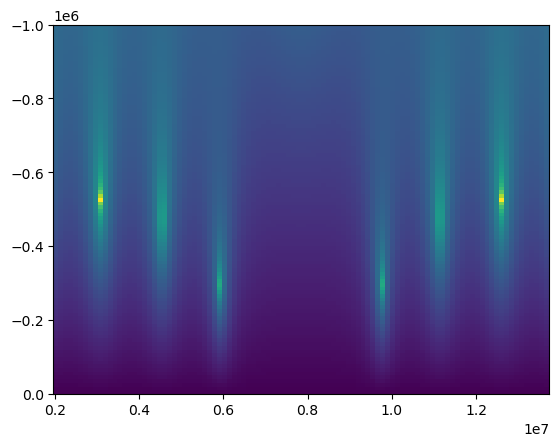

In [61]:
# Plot pole landscape for unperturbed system
# Compare with 
"""Exact Coupled-Mode Theories for
Multilayer Interference Coatings with
Arbitrary Strong Index Modulations"""

fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data),
    extent=(k0_min.real, k0_max.real, 0.0, k0_min_imag.imag),
    aspect="auto",
)

In [82]:
S = get_S(2*np.pi/(500e-9) - 1e5j)

In [83]:
S11 = S[0,0]
S12 = S[0,1]
S21 = S[1,0]
S22 = S[1,1]
M = np.array([[S21 - S22*S11/S12, S22/S12],[-S11/S12, 1/S12]])

In [84]:
print(M)
print(np.linalg.det(M))
print(S)
print(S@np.conj(S.T))

[[ 1.25019925-0.35366835j  0.19370204-0.1342829j ]
 [-0.10429635+0.2168657j   0.73547476+0.25286104j]]
(0.9999999999999998+0j)
[[0.03615775-0.30729618j 1.21593846-0.41804761j]
 [1.21593846-0.41804761j 0.17939312-0.24425642j]]
[[1.74900846+0.j         0.49267184-0.13653168j]
 [0.49267184+0.13653168j 1.74511323+0.j        ]]


In [45]:
# Find poles of unperturbed system
num_poles = 100
pole_guesses = 1.142e7 + np.array(
    [3825 - 60j, 3925 - 60j], dtype=np.complex128
)
poles = [utils.find_pole(get_S_inv, guess) for guess in pole_guesses]
fsr = poles[1] - poles[0]

poles = [poles[0] + i * fsr for i in range(num_poles)]
poles = [utils.find_pole(get_S_inv, pole) for pole in poles]

In [6]:
# Perturb the sytem
Dn = 1e-6
n_perturbed = copy.deepcopy(n)
n_perturbed[n_index] += Dn

# new S matrix function (and inverse)
get_S_perturbed = functools.partial(multilayer.get_S, n=n_perturbed, L=L)
get_S_inv_perturbed = functools.partial(
    multilayer.get_S_inv, n=n_perturbed, L=L
)

In [7]:
# Pole landscape sweep for perturbed system
x, y, data_perturbed = utils.sweep(
    k0_min, k0_max, num_points, get_S_inv_perturbed
)

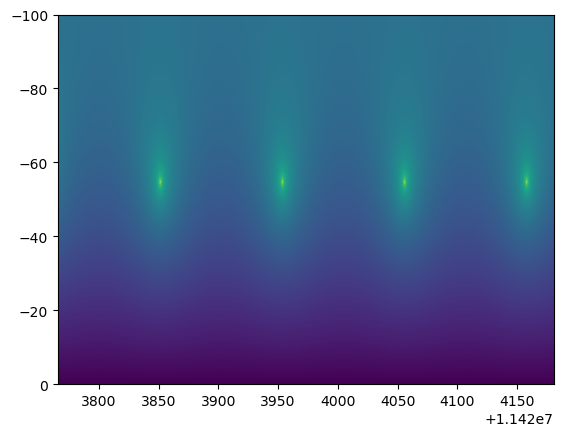

In [8]:
# Plot new pole landscape
fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data_perturbed),
    extent=(k0_min.real, k0_max.real, 0.0, -100),
    aspect="auto",
)

In [9]:
# Find new poles for perturbed system
poles_perturbed = [
    utils.find_pole(get_S_inv_perturbed, guess) for guess in poles
]

In [10]:
# Work out what the pole shift should be using perturbation theory
poles_perturbed_theory = []
for pole in poles:
    ws_n_res = utils.get_residue(
        functools.partial(multilayer.get_ws_n, n=n, L=L, n_index=n_index),
        pole,
        radius=0.1,
    )
    shift = 1j * np.trace(ws_n_res) * Dn
    new_pole = pole + shift
    poles_perturbed_theory.append(new_pole)

In [11]:
# Test the residue result for k0 WS
ws_k0_res = utils.get_residue(
    functools.partial(multilayer.get_ws_k0, n=n, L=L), poles[4], radius=1e-2
)
print(np.trace(ws_k0_res))

(7.296193663020942e-09+1.0000158262300638j)


In [12]:
# Verify the pole order by checking that only one eigenvalue diverges
l, w = np.linalg.eig(get_S(poles[0]))
print(l)

[-2.77611648e+00+8.64028193e-02j  3.84778143e+10+3.03657365e+09j]


In [15]:
# Differences between poles predicted from theory and calculated numerically
diff = (
    np.array(poles_perturbed_theory) - np.array(poles_perturbed)
) / np.array(poles_perturbed)
print(diff)

[ 6.52429238e-15-4.89309023e-13j -3.79248179e-13+1.77324127e-14j
  6.82511131e-13-2.33221906e-13j -6.02121804e-13-2.51756840e-13j
  3.79726102e-13+1.94263753e-13j  1.06189471e-12-1.13190877e-12j
 -2.43891596e-12-4.03025241e-14j  1.77451027e-12+3.38969960e-13j
 -1.02501295e-12-2.92053826e-13j  1.03918994e-12-1.48207468e-13j
 -8.45656509e-13-3.88722413e-13j  3.30466949e-13+8.31197296e-14j
  1.73631076e-13-5.85831971e-13j -1.21685605e-12+3.36998148e-13j
  1.70658443e-12-8.01170804e-13j -5.72845904e-12+4.45609844e-12j
  1.43449490e-11-4.14838106e-12j -1.31666124e-11-4.83490527e-12j
  4.36279047e-12+4.06022510e-12j -1.41485695e-12-6.73347065e-13j
  8.57807714e-13+3.40940174e-13j  3.14648008e-14-4.78883083e-13j
 -3.83415355e-13+8.04244053e-15j  6.63799150e-13-2.14967809e-13j
 -5.50333315e-13-2.63169214e-13j  3.01897584e-13+2.63309608e-13j
  1.39586841e-12-1.28871157e-12j -2.96057720e-12-7.31133917e-14j
  2.05927731e-12+4.96313544e-13j -1.08431768e-12-3.33298402e-13j
  1.08056105e-12-1.337129